## Telecom churn case study

### Business Understanding

Telecommunications industry expreirences an average of 15-25% annual churn rate. 

### Team Members:

### 1. Sourabh Mishra

### 2. Krishna

### Objective

Objective is to understand the driving factors(for customer behavior) which results into churn and create a model to predict the churn in the last month.

First pull all the lib that we need

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
    
pd.set_option("display.max_columns", 300)
pd.set_option("display.max_rows", 300)

Load the telecom churn data into dataframe

In [2]:
churn = pd.read_csv("telecom_churn_data.csv", sep=',', encoding='ISO-8859-1') # VIVA Questions: the reason to use this encoding.
print(churn.shape)

(99999, 226)


In [3]:
# feature type summary
churn.info(verbose=1)
print(churn.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   mobile_number             int64  
 1   circle_id                 int64  
 2   loc_og_t2o_mou            float64
 3   std_og_t2o_mou            float64
 4   loc_ic_t2o_mou            float64
 5   last_date_of_month_6      object 
 6   last_date_of_month_7      object 
 7   last_date_of_month_8      object 
 8   last_date_of_month_9      object 
 9   arpu_6                    float64
 10  arpu_7                    float64
 11  arpu_8                    float64
 12  arpu_9                    float64
 13  onnet_mou_6               float64
 14  onnet_mou_7               float64
 15  onnet_mou_8               float64
 16  onnet_mou_9               float64
 17  offnet_mou_6              float64
 18  offnet_mou_7              float64
 19  offnet_mou_8              float64
 20  offnet_mou_9              f

There are 99999 rows and 226 columns in the data. Lot of the columns are numeric type, but we need to inspect which are the categorical columns.

In [4]:
# look at data statistics
churn.describe(include='all')

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999,99398,98899,98340,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000

In [5]:
# create backup of data
original = churn.copy()

In [6]:
# create column name list by types of columns
id_cols = ['mobile_number', 'circle_id']

date_cols = ['last_date_of_month_6',
             'last_date_of_month_7',
             'last_date_of_month_8',
             'last_date_of_month_9',
             'date_of_last_rech_6',
             'date_of_last_rech_7',
             'date_of_last_rech_8',
             'date_of_last_rech_9',
             'date_of_last_rech_data_6',
             'date_of_last_rech_data_7',
             'date_of_last_rech_data_8',
             'date_of_last_rech_data_9'
            ]

cat_cols =  ['night_pck_user_6',
             'night_pck_user_7',
             'night_pck_user_8',
             'night_pck_user_9',
             'fb_user_6',
             'fb_user_7',
             'fb_user_8',
             'fb_user_9'
            ]

num_cols = [column for column in churn.columns if column not in id_cols + date_cols + cat_cols]

# print the number of columns in each list
print("#ID cols: %d\n#Date cols:%d\n#Numeric cols:%d\n#Category cols:%d" % (len(id_cols), len(date_cols), len(num_cols), len(cat_cols)))

# check if we have missed any column or not
print(len(id_cols) + len(date_cols) + len(num_cols) + len(cat_cols) == churn.shape[1])

#ID cols: 2
#Date cols:12
#Numeric cols:204
#Category cols:8
True


# Handling missing values

In [7]:
# look at missing value ratio in each column
churn.isnull().sum()*100/churn.shape[0]

mobile_number                0.000000
circle_id                    0.000000
loc_og_t2o_mou               1.018010
std_og_t2o_mou               1.018010
loc_ic_t2o_mou               1.018010
last_date_of_month_6         0.000000
last_date_of_month_7         0.601006
last_date_of_month_8         1.100011
last_date_of_month_9         1.659017
arpu_6                       0.000000
arpu_7                       0.000000
arpu_8                       0.000000
arpu_9                       0.000000
onnet_mou_6                  3.937039
onnet_mou_7                  3.859039
onnet_mou_8                  5.378054
onnet_mou_9                  7.745077
offnet_mou_6                 3.937039
offnet_mou_7                 3.859039
offnet_mou_8                 5.378054
offnet_mou_9                 7.745077
roam_ic_mou_6                3.937039
roam_ic_mou_7                3.859039
roam_ic_mou_8                5.378054
roam_ic_mou_9                7.745077
roam_og_mou_6                3.937039
roam_og_mou_

# impute missing values

## i) Imputing with zeroes

In [8]:
# some recharge columns have minimum value of 1 while some don't
recharge_cols = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9',
                 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9',
                 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9',
                 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9',
                 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9',
                 ]

churn[recharge_cols].describe(include='all')

,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9
count,25153.000000,25571.000000,26339.000000,25922.000000,25153.000000,25571.000000,26339.000000,25922.000000,25153.000000,25571.000000,26339.000000,25922.000000,25153.000000,25571.000000,26339.000000,25922.00000,25153.000000,25571.000000,26339.000000,25922.000000
mean,2.463802,2.666419,2.651999,2.441170,1.864668,2.044699,2.016288,1.781807,0.599133,0.621720,0.635711,0.659363,126.393392,126.729459,125.717301,124.94144,192.600982,200.981292,197.526489,192.734315
std,2.789128,3.031593,3.074987,2.516339,2.570254,2.768332,2.720132,2.214701,1.274428,1.394524,1.422827,1.411513,108.477235,109.765267,109.437851,111.36376,192.646318,196.791224,191.301305,188.400286
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.500000,0.500000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,25.000000,25.00000,82.000000,92.000000,87.000000,69.000000
50%,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,145.000000,145.000000,145.000000,145.00000,154.000000,154.000000,154.000000,164.000000
75%,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,177.000000,177.000000,179.000000,179.00000,252.000000,252.000000,252.000000,252.000000
max,61.000000,54.000000,60.000000,84.000000,42.000000,48.000000,44.000000,40.000000,29.000000,35.000000,45.000000,49.000000,1555.000000,1555.000000,1555.000000,1555.00000,7546.000000,4365.000000,4076.000000,4061.000000


In [9]:
# It is also observed that the recharge date and the recharge value are missing together which means the customer didn't recharge
churn.loc[churn.total_rech_data_6.isnull() & churn.date_of_last_rech_data_6.isnull(), ["total_rech_data_6", "date_of_last_rech_data_6"]].head(20)

,total_rech_data_6,date_of_last_rech_data_6
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN
10,NaN,NaN
11,NaN,NaN


In the recharge variables where minumum value is 1, we can impute missing values with zeroes since it means customer didn't recharge their numbere that month.

In [10]:
# create a list of recharge columns where we will impute missing values with zeroes
zero_impute = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9',
        'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9',
        'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9'
       ]

In [11]:
# impute missing values with 0
churn[zero_impute] = churn[zero_impute].apply(lambda x: x.fillna(0))

In [12]:
# now, let's make sure values are imputed correctly
print("Missing value ratio:\n")
print(churn[zero_impute].isnull().sum()*100/churn.shape[1])

# summary
print("\n\nSummary statistics\n")
print(churn[zero_impute].describe(include='all'))

Missing value ratio:

total_rech_data_6     0.0
total_rech_data_7     0.0
total_rech_data_8     0.0
total_rech_data_9     0.0
av_rech_amt_data_6    0.0
av_rech_amt_data_7    0.0
av_rech_amt_data_8    0.0
av_rech_amt_data_9    0.0
max_rech_data_6       0.0
max_rech_data_7       0.0
max_rech_data_8       0.0
max_rech_data_9       0.0
dtype: float64


Summary statistics

       total_rech_data_6  total_rech_data_7  total_rech_data_8  \
count       99999.000000       99999.000000       99999.000000   
mean            0.619726           0.681837           0.698517   
std             1.760541           1.924382           1.963417   
min             0.000000           0.000000           0.000000   
25%             0.000000           0.000000           0.000000   
50%             0.000000           0.000000           0.000000   
75%             1.000000           1.000000           1.000000   
max            61.000000          54.000000          60.000000   

       total_rech_data_9  av_rech_

In [13]:
# drop id and date columns
print("Shape before dropping: ", churn.shape)
churn = churn.drop(id_cols + date_cols, axis=1)
print("Shape after dropping: ", churn.shape)

Shape before dropping:  (99999, 226)
Shape after dropping:  (99999, 212)


## ii) Replace NaN values in categorical variables

We will replace missing values in the categorical values with '-1' where '-1' will be a new category.

In [14]:
# replace missing values with '-1' in categorical columns
churn[cat_cols] = churn[cat_cols].apply(lambda x: x.fillna(-1))

In [15]:
# missing value ratio
print("Missing value ratio:\n")
print(churn[cat_cols].isnull().sum()*100/churn.shape[0])

Missing value ratio:

night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
night_pck_user_9    0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
fb_user_9           0.0
dtype: float64


## iii) Drop variables with more than a given threshold of missing values

In [16]:
initial_cols = churn.shape[1]

MISSING_THRESHOLD = 0.7

include_cols = list(churn.apply(lambda column: True if column.isnull().sum()/churn.shape[0] < MISSING_THRESHOLD else False))

drop_missing = pd.DataFrame({'features':churn.columns , 'include': include_cols})
drop_missing.loc[drop_missing.include == True,:]

,features,include
0,loc_og_t2o_mou,True
1,std_og_t2o_mou,True
2,loc_ic_t2o_mou,True
3,arpu_6,True
4,arpu_7,True
5,arpu_8,True
6,arpu_9,True
7,onnet_mou_6,True
8,onnet_mou_7,True
9,onnet_mou_8,True


In [17]:
# drop columns
churn = churn.loc[:, include_cols]

dropped_cols = churn.shape[1] - initial_cols
print("{0} columns dropped.".format(dropped_cols))


-16 columns dropped.


In [18]:
# check the missing value again
print(churn.isnull().sum()*100/churn.shape[0])
print(churn.shape)


loc_og_t2o_mou        1.018010
std_og_t2o_mou        1.018010
loc_ic_t2o_mou        1.018010
arpu_6                0.000000
arpu_7                0.000000
arpu_8                0.000000
arpu_9                0.000000
onnet_mou_6           3.937039
onnet_mou_7           3.859039
onnet_mou_8           5.378054
onnet_mou_9           7.745077
offnet_mou_6          3.937039
offnet_mou_7          3.859039
offnet_mou_8          5.378054
offnet_mou_9          7.745077
roam_ic_mou_6         3.937039
roam_ic_mou_7         3.859039
roam_ic_mou_8         5.378054
roam_ic_mou_9         7.745077
roam_og_mou_6         3.937039
roam_og_mou_7         3.859039
roam_og_mou_8         5.378054
roam_og_mou_9         7.745077
loc_og_t2t_mou_6      3.937039
loc_og_t2t_mou_7      3.859039
loc_og_t2t_mou_8      5.378054
loc_og_t2t_mou_9      7.745077
loc_og_t2m_mou_6      3.937039
loc_og_t2m_mou_7      3.859039
loc_og_t2m_mou_8      5.378054
loc_og_t2m_mou_9      7.745077
loc_og_t2f_mou_6      3.937039
loc_og_t

#### We are left with few columns with around 4% of null values

In [19]:
# REVISIT THIS AS IT'S NOT GOOD TO DROP THE VALUES DO IMPUTATION USING OTHER TECHNIQUES
churn = churn.dropna()
print(churn.isnull().sum()*100/churn.shape[0])

loc_og_t2o_mou        0.0
std_og_t2o_mou        0.0
loc_ic_t2o_mou        0.0
arpu_6                0.0
arpu_7                0.0
arpu_8                0.0
arpu_9                0.0
onnet_mou_6           0.0
onnet_mou_7           0.0
onnet_mou_8           0.0
onnet_mou_9           0.0
offnet_mou_6          0.0
offnet_mou_7          0.0
offnet_mou_8          0.0
offnet_mou_9          0.0
roam_ic_mou_6         0.0
roam_ic_mou_7         0.0
roam_ic_mou_8         0.0
roam_ic_mou_9         0.0
roam_og_mou_6         0.0
roam_og_mou_7         0.0
roam_og_mou_8         0.0
roam_og_mou_9         0.0
loc_og_t2t_mou_6      0.0
loc_og_t2t_mou_7      0.0
loc_og_t2t_mou_8      0.0
loc_og_t2t_mou_9      0.0
loc_og_t2m_mou_6      0.0
loc_og_t2m_mou_7      0.0
loc_og_t2m_mou_8      0.0
loc_og_t2m_mou_9      0.0
loc_og_t2f_mou_6      0.0
loc_og_t2f_mou_7      0.0
loc_og_t2f_mou_8      0.0
loc_og_t2f_mou_9      0.0
loc_og_t2c_mou_6      0.0
loc_og_t2c_mou_7      0.0
loc_og_t2c_mou_8      0.0
loc_og_t2c_m

# filter high-value customers

### calculate total data recharge amount

In [20]:
# calculate the total data recharge amount for June and July --> number of recharges * average recharge amount
churn['total_data_rech_6'] = churn.total_rech_data_6 * churn.av_rech_amt_data_6
churn['total_data_rech_7'] = churn.total_rech_data_7 * churn.av_rech_amt_data_7

### add total data recharge and total recharge to get total combined recharge amount for a month

In [21]:
# calculate total recharge amount for June and July --> call recharge amount + data recharge amount
churn['amt_data_6'] = churn.total_rech_amt_6 + churn.total_data_rech_6
churn['amt_data_7'] = churn.total_rech_amt_7 + churn.total_data_rech_7

In [22]:
# calculate average recharge done by customer in June and July
churn['av_amt_data_6_7'] = (churn.amt_data_6 + churn.amt_data_7)/2

In [23]:
# look at the 70th percentile recharge amount
print("Recharge amount at 70th percentile: {0}".format(churn.av_amt_data_6_7.quantile(0.7)))

Recharge amount at 70th percentile: 497.0


In [24]:
# retain only those customers who have recharged their mobiles with more than or equal to 70th percentile amount
churn_filtered = churn.loc[churn.av_amt_data_6_7 >= churn.av_amt_data_6_7.quantile(0.7), :]
churn_filtered = churn_filtered.reset_index(drop=True)
churn_filtered.shape

(26501, 201)

In [25]:
# delete variables created to filter high-value customers
churn_filtered = churn_filtered.drop(['total_data_rech_6', 'total_data_rech_7',
                                      'amt_data_6', 'amt_data_7', 'av_amt_data_6_7'], axis=1)
churn_filtered.shape

(26501, 196)

We're left with 30,001 rows after selecting the customers who have provided recharge value of more than or equal to the recharge value of the 70th percentile customer.

#### Calculate Churn based on total ic/og calls and 2g/3g data volumes


In [26]:
# calculate total incoming and outgoing minutes of usage
churn_filtered['total_calls_mou_9'] = churn_filtered.total_ic_mou_9 + churn_filtered.total_og_mou_9

In [27]:
# calculate 2g and 3g data consumption
churn_filtered['total_internet_mb_9'] =  churn_filtered.vol_2g_mb_9 + churn_filtered.vol_3g_mb_9

In [28]:
# create churn variable: those who have not used either calls or internet in the month of September are customers who have churned

# 0 - not churn, 1 - churn
churn_filtered['churn'] = churn_filtered.apply(lambda row: 1 if (row.total_calls_mou_9 == 0 and row.total_internet_mb_9 == 0) else 0, axis=1)

In [29]:
# delete derived variables
churn_filtered = churn_filtered.drop(['total_calls_mou_9', 'total_internet_mb_9'], axis=1)

In [30]:
# change data type to category
churn_filtered.churn = churn_filtered.churn.astype("category")

# print churn ratio
print("Churn Ratio:")
print(churn_filtered.churn.value_counts())

Churn Ratio:
0    25775
1      726
Name: churn, dtype: int64


# Calculate difference between 8th and previous months

Let's derive some variables. The most important feature, in this situation, can be the difference between the 8th month and the previous months. The difference can be in patterns such as usage difference or recharge value difference. Let's calculate difference variable as the difference between 8th month and the average of 6th and 7th month.

In [31]:
churn_filtered['arpu_diff'] = churn_filtered.arpu_8 - ((churn_filtered.arpu_6 + churn_filtered.arpu_7)/2)

churn_filtered['onnet_mou_diff'] = churn_filtered.onnet_mou_8 - ((churn_filtered.onnet_mou_6 + churn_filtered.onnet_mou_7)/2)

churn_filtered['offnet_mou_diff'] = churn_filtered.offnet_mou_8 - ((churn_filtered.offnet_mou_6 + churn_filtered.offnet_mou_7)/2)

churn_filtered['roam_ic_mou_diff'] = churn_filtered.roam_ic_mou_8 - ((churn_filtered.roam_ic_mou_6 + churn_filtered.roam_ic_mou_7)/2)

churn_filtered['roam_og_mou_diff'] = churn_filtered.roam_og_mou_8 - ((churn_filtered.roam_og_mou_6 + churn_filtered.roam_og_mou_7)/2)

churn_filtered['loc_og_mou_diff'] = churn_filtered.loc_og_mou_8 - ((churn_filtered.loc_og_mou_6 + churn_filtered.loc_og_mou_7)/2)

churn_filtered['std_og_mou_diff'] = churn_filtered.std_og_mou_8 - ((churn_filtered.std_og_mou_6 + churn_filtered.std_og_mou_7)/2)

churn_filtered['isd_og_mou_diff'] = churn_filtered.isd_og_mou_8 - ((churn_filtered.isd_og_mou_6 + churn_filtered.isd_og_mou_7)/2)

churn_filtered['spl_og_mou_diff'] = churn_filtered.spl_og_mou_8 - ((churn_filtered.spl_og_mou_6 + churn_filtered.spl_og_mou_7)/2)

churn_filtered['total_og_mou_diff'] = churn_filtered.total_og_mou_8 - ((churn_filtered.total_og_mou_6 + churn_filtered.total_og_mou_7)/2)

churn_filtered['loc_ic_mou_diff'] = churn_filtered.loc_ic_mou_8 - ((churn_filtered.loc_ic_mou_6 + churn_filtered.loc_ic_mou_7)/2)

churn_filtered['std_ic_mou_diff'] = churn_filtered.std_ic_mou_8 - ((churn_filtered.std_ic_mou_6 + churn_filtered.std_ic_mou_7)/2)

churn_filtered['isd_ic_mou_diff'] = churn_filtered.isd_ic_mou_8 - ((churn_filtered.isd_ic_mou_6 + churn_filtered.isd_ic_mou_7)/2)

churn_filtered['spl_ic_mou_diff'] = churn_filtered.spl_ic_mou_8 - ((churn_filtered.spl_ic_mou_6 + churn_filtered.spl_ic_mou_7)/2)

churn_filtered['total_ic_mou_diff'] = churn_filtered.total_ic_mou_8 - ((churn_filtered.total_ic_mou_6 + churn_filtered.total_ic_mou_7)/2)

churn_filtered['total_rech_num_diff'] = churn_filtered.total_rech_num_8 - ((churn_filtered.total_rech_num_6 + churn_filtered.total_rech_num_7)/2)

churn_filtered['total_rech_amt_diff'] = churn_filtered.total_rech_amt_8 - ((churn_filtered.total_rech_amt_6 + churn_filtered.total_rech_amt_7)/2)

churn_filtered['max_rech_amt_diff'] = churn_filtered.max_rech_amt_8 - ((churn_filtered.max_rech_amt_6 + churn_filtered.max_rech_amt_7)/2)

churn_filtered['total_rech_data_diff'] = churn_filtered.total_rech_data_8 - ((churn_filtered.total_rech_data_6 + churn_filtered.total_rech_data_7)/2)

churn_filtered['max_rech_data_diff'] = churn_filtered.max_rech_data_8 - ((churn_filtered.max_rech_data_6 + churn_filtered.max_rech_data_7)/2)

churn_filtered['av_rech_amt_data_diff'] = churn_filtered.av_rech_amt_data_8 - ((churn_filtered.av_rech_amt_data_6 + churn_filtered.av_rech_amt_data_7)/2)

churn_filtered['vol_2g_mb_diff'] = churn_filtered.vol_2g_mb_8 - ((churn_filtered.vol_2g_mb_6 + churn_filtered.vol_2g_mb_7)/2)

churn_filtered['vol_3g_mb_diff'] = churn_filtered.vol_3g_mb_8 - ((churn_filtered.vol_3g_mb_6 + churn_filtered.vol_3g_mb_7)/2)

## Remove columns for 9th month, we don't need them any more

In [91]:
# delete all variables relating to 9th month
churn_filtered = churn_filtered.filter(regex='[^9]$', axis=1)
churn_filtered.shape

(26501, 173)

In [34]:
# extract all names that end with 9
col_9_names = churn.filter(regex='9$', axis=1).columns

# update num_cols and cat_cols column name list
cat_cols = [col for col in cat_cols if col not in col_9_names]
cat_cols.append('churn')
num_cols = [col for col in churn_filtered.columns if col not in cat_cols]

## Data Visualization

In [35]:
# change columns types
churn_filtered[num_cols] = churn_filtered[num_cols].apply(pd.to_numeric)
churn_filtered[cat_cols] = churn_filtered[cat_cols].apply(lambda column: column.astype("category"), axis=0)

In [36]:
# create plotting functions
def data_type(variable):
    if variable.dtype == np.int64 or variable.dtype == np.float64:
        return 'numerical'
    elif variable.dtype == 'category':
        return 'categorical'
    
def univariate(variable, stats=True):
    
    if data_type(variable) == 'numerical':
        sns.distplot(variable)
        if stats == True:
            print(variable.describe())
    
    elif data_type(variable) == 'categorical':
        sns.countplot(variable)
        if stats == True:
            print(variable.value_counts())
            
    else:
        print("Invalid variable passed: either pass a numeric variable or a categorical vairable.")
        
def bivariate(var1, var2):
    if data_type(var1) == 'numerical' and data_type(var2) == 'numerical':
        sns.regplot(var1, var2)
    elif (data_type(var1) == 'categorical' and data_type(var2) == 'numerical') or (data_type(var1) == 'numerical' and data_type(var2) == 'categorical'):        
        sns.boxplot(var1, var2)

## Univariate EDA

count    88327.000000
mean       290.234047
std        325.035262
min      -2258.709000
25%        100.512000
50%        204.699000
75%        378.510000
max      27731.088000
Name: arpu_6, dtype: float64


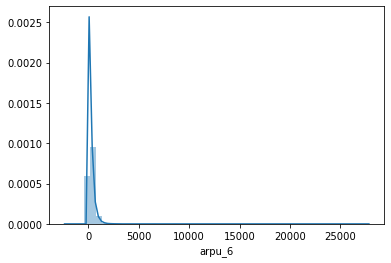

In [37]:
univariate(churn.arpu_6)

count    88327.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: loc_og_t2o_mou, dtype: float64


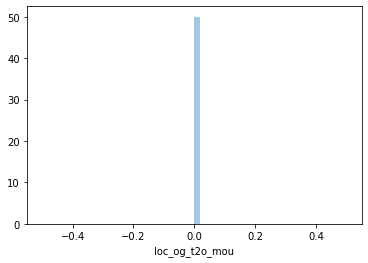

In [38]:
univariate(churn.loc_og_t2o_mou)

count    88327.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: std_og_t2o_mou, dtype: float64


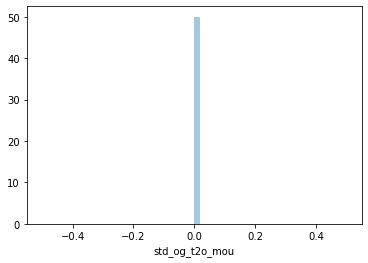

In [39]:
univariate(churn.std_og_t2o_mou)

count    88327.000000
mean       134.949279
std        311.250923
min          0.000000
25%          7.210000
50%         33.530000
75%        117.890000
max      10752.560000
Name: onnet_mou_8, dtype: float64


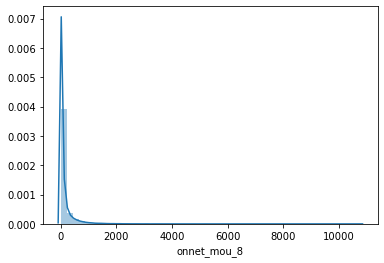

In [40]:
univariate(churn.onnet_mou_8)

count    88327.000000
mean       190.106687
std        316.477661
min          0.000000
25%         28.380000
50%         88.430000
75%        220.655000
max      10310.760000
Name: offnet_mou_9, dtype: float64


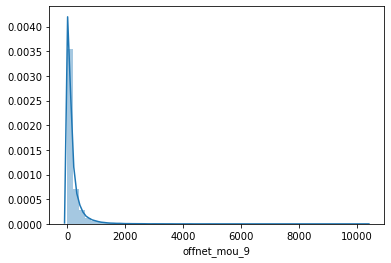

In [41]:
univariate(churn.offnet_mou_9)

Variables are very **skewed** towards the left.

## Bivariate EDA

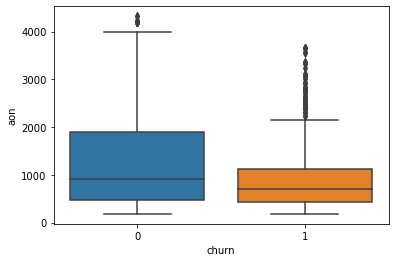

In [42]:
bivariate(churn_filtered.churn, churn_filtered.aon)

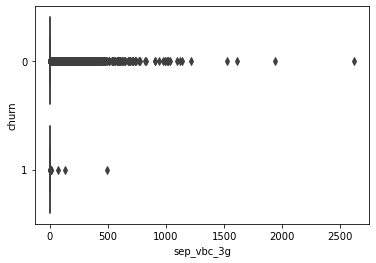

In [43]:
bivariate(churn_filtered.sep_vbc_3g, churn_filtered.churn)

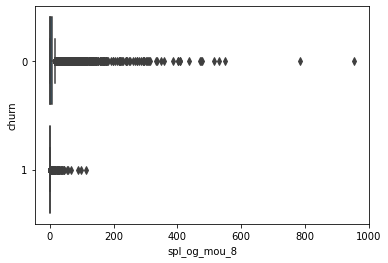

In [44]:
bivariate(churn_filtered.spl_og_mou_8, churn_filtered.churn)

In [45]:
pd.crosstab(churn_filtered.churn, churn_filtered.night_pck_user_8, normalize='columns')*100

night_pck_user_8,-1.0,0.0,1.0
churn,,,
0,94.956477,99.107822,98.148148
1,5.043523,0.892178,1.851852


In [46]:
pd.crosstab(churn_filtered.churn, churn_filtered.sachet_3g_8)

sachet_3g_8,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,25,27,29,30,38,41
churn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,23331,1523,373,173,100,81,40,33,26,17,15,8,11,10,6,5,2,2,3,1,3,3,2,1,1,1,2,1,1
1,705,11,3,3,0,2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Cap outliers in all numeric variables

In [47]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [48]:
# example of capping
sample_array = list(range(100))

# add outliers to the data
sample_array[0] = -9999
sample_array[99] = 9999

# cap outliers
sample_array = np.array(sample_array)
print("Array after capping outliers: \n", cap_outliers(sample_array, k=2))

Array after capping outliers: 
 [-2780     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    51    52    53    54    55    56    57    58    59
    60    61    62    63    64    65    66    67    68    69    70    71
    72    73    74    75    76    77    78    79    80    81    82    83
    84    85    86    87    88    89    90    91    92    93    94    95
    96    97    98  2877]


In [49]:
# cap outliers in the numeric columns
churn_filtered[num_cols] = churn_filtered[num_cols].apply(cap_outliers, axis=0)

# Modelling

## i) Making predictions

In [50]:
# import required libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from imblearn.metrics import sensitivity_specificity_support
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

## Preprocessing data

In [51]:
# change churn to numeric
churn_filtered['churn'] = pd.to_numeric(churn_filtered['churn'])

### Train Test split

In [52]:
# divide data into train and test
X = churn_filtered.drop("churn", axis = 1)
y = churn_filtered.churn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 4, stratify = y)

In [53]:
# print shapes of train and test sets
X_train.shape
y_train.shape
X_test.shape
y_test.shape

(6626,)

## Aggregating the categorical columns

In [54]:
train = pd.concat([X_train, y_train], axis=1)

# aggregate the categorical variables
train.groupby('night_pck_user_6').churn.mean()
train.groupby('night_pck_user_7').churn.mean()
train.groupby('night_pck_user_8').churn.mean()
train.groupby('fb_user_6').churn.mean()
train.groupby('fb_user_7').churn.mean()
train.groupby('fb_user_8').churn.mean()

fb_user_8
-1.0    0.051909
 0.0    0.033101
 1.0    0.005210
Name: churn, dtype: float64

In [55]:
# replace categories with aggregated values in each categorical column
mapping = {'night_pck_user_6' : {-1: 0.099165, 0: 0.066797, 1: 0.087838},
           'night_pck_user_7' : {-1: 0.115746, 0: 0.055494, 1: 0.051282},
           'night_pck_user_8' : {-1: 0.141108, 0: 0.029023, 1: 0.016194},
           'fb_user_6'        : {-1: 0.099165, 0: 0.069460, 1: 0.067124},
           'fb_user_7'        : {-1: 0.115746, 0: 0.059305, 1: 0.055082},
           'fb_user_8'        : {-1: 0.141108, 0: 0.066887, 1: 0.024463}
          }
X_train.replace(mapping, inplace = True)
X_test.replace(mapping, inplace = True)

In [56]:
# check data type of categorical columns - make sure they are numeric
X_train[[col for col in cat_cols if col not in ['churn']]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19875 entries, 15938 to 22963
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   night_pck_user_6  19875 non-null  float64
 1   night_pck_user_7  19875 non-null  float64
 2   night_pck_user_8  19875 non-null  float64
 3   fb_user_6         19875 non-null  float64
 4   fb_user_7         19875 non-null  float64
 5   fb_user_8         19875 non-null  float64
dtypes: float64(6)
memory usage: 1.1 MB


## PCA

In [57]:
# apply pca to train data
pca = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])

In [58]:
pca.fit(X_train)
churn_pca = pca.fit_transform(X_train)

In [59]:
# extract pca model from pipeline
pca = pca.named_steps['pca']

# look at explainded variance of PCA components
print(pd.Series(np.round(pca.explained_variance_ratio_.cumsum(), 4)*100))

0       11.57
1       21.14
2       26.76
3       31.54
4       35.61
5       39.35
6       42.14
7       44.71
8       47.05
9       49.25
10      51.30
11      53.25
12      55.02
13      56.75
14      58.40
15      59.89
16      61.29
17      62.65
18      63.94
19      65.17
20      66.35
21      67.52
22      68.64
23      69.73
24      70.76
25      71.73
26      72.69
27      73.61
28      74.51
29      75.38
30      76.21
31      77.03
32      77.83
33      78.61
34      79.38
35      80.12
36      80.86
37      81.56
38      82.22
39      82.87
40      83.50
41      84.06
42      84.61
43      85.15
44      85.68
45      86.19
46      86.69
47      87.16
48      87.62
49      88.06
50      88.48
51      88.87
52      89.25
53      89.62
54      89.98
55      90.33
56      90.68
57      91.01
58      91.33
59      91.65
60      91.96
61      92.26
62      92.55
63      92.83
64      93.10
65      93.37
66      93.63
67      93.88
68      94.12
69      94.35
70      94.57
71    

~ 60 components explain 90% variance

~ 80 components explain 95% variance

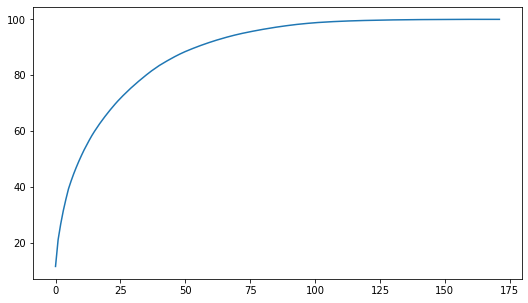

In [60]:
# plot feature variance
features = range(pca.n_components_)
cumulative_variance = np.round(np.cumsum(pca.explained_variance_ratio_)*100, decimals=4)
plt.figure(figsize=(175/20,100/20)) # 100 elements on y-axis; 175 elements on x-axis; 20 is normalising factor
plt.plot(cumulative_variance)

## PCA and Logistic Regression

In [61]:
# create pipeline
PCA_VARS = 60
steps = [('scaler', StandardScaler()),
         ("pca", PCA(n_components=PCA_VARS)),
         ("logistic", LogisticRegression(class_weight='balanced'))
        ]
pipeline = Pipeline(steps)

In [62]:
# fit model
pipeline.fit(X_train, y_train)

# check score on train data
pipeline.score(X_train, y_train)

0.8432201257861636

### Evaluate on test data

In [63]:
# predict churn on test data
y_pred = pipeline.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[5439 1005]
 [  27  155]]
Sensitivity: 	0.85
Specificity: 	0.84
AUC:    	 0.92


### Hyperparameter tuning - PCA and Logistic Regression

In [64]:
# class imbalance
y_train.value_counts()/y_train.shape

0    0.972629
1    0.027371
Name: churn, dtype: float64

In [65]:
# PCA
pca = PCA()

# logistic regression - the class weight is used to handle class imbalance - it adjusts the cost function
logistic = LogisticRegression(class_weight={0:0.1, 1: 0.9})

# create pipeline
steps = [("scaler", StandardScaler()), 
         ("pca", pca),
         ("logistic", logistic)
        ]

# compile pipeline
pca_logistic = Pipeline(steps)

# hyperparameter space
params = {'pca__n_components': [60, 80], 'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=pca_logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [66]:
# fit model
model.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  1.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('logistic',
                                        LogisticRegression(class_weight={0: 0.1,
                                                                         1: 0.9}))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                         'logistic__penalty': ['l1', 'l2'],
                         'pca__n_components': [60, 80]},
             scoring='roc_auc', verbose=1)

In [67]:
# cross validation results
pd.DataFrame(model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_logistic__penalty,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.745734,0.060902,0.000000,0.000000,0.1,l1,60,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,32
1,2.291873,0.047468,0.000000,0.000000,0.1,l1,80,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,28
2,2.321992,0.056773,0.050266,0.002931,0.1,l2,60,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'...",0.910259,0.933998,0.916292,0.936886,0.890492,0.917585,0.016919,2
3,2.748850,0.070404,0.055451,0.011555,0.1,l2,80,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'...",0.907206,0.934479,0.918444,0.937275,0.891819,0.917845,0.017001,1
4,1.850452,0.094211,0.000000,0.000000,0.5,l1,60,"{'logistic__C': 0.5, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,27
5,2.181568,0.071114,0.000000,0.000000,0.5,l1,80,"{'logistic__C': 0.5, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,24
6,0.903377,0.597061,0.018357,0.005411,0.5,l2,60,"{'logistic__C': 0.5, 'logistic__penalty': 'l2'...",0.905600,0.932382,0.917469,0.936461,0.890938,0.916570,0.016875,3
7,0.797857,0.045823,0.017367,0.001344,0.5,l2,80,"{'logistic__C': 0.5, 'logistic__penalty': 'l2'...",0.897509,0.931677,0.919277,0.935528,0.891707,0.915140,0.017699,10
8,1.468884,0.511699,0.000000,0.000000,1,l1,60,"{'logistic__C': 1, 'logistic__penalty': 'l1', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,23
9,2.437285,0.042462,0.000000,0.000000,1,l1,80,"{'logistic__C': 1, 'logistic__penalty': 'l1', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,20


In [68]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.9178447159582988
Best hyperparameters:  {'logistic__C': 0.1, 'logistic__penalty': 'l2', 'pca__n_components': 80}


In [69]:
# predict churn on test data
y_pred = model.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[6184  260]
 [  65  117]]
Sensitivity: 	0.64
Specificity: 	0.96
AUC:    	 0.92


### Random Forest

In [70]:
# random forest - the class weight is used to handle class imbalance - it adjusts the cost function
forest = RandomForestClassifier(class_weight={0:0.1, 1: 0.9}, n_jobs = -1)

# hyperparameter space
params = {"criterion": ['gini', 'entropy'], "max_features": ['auto', 0.4]}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=forest, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [71]:
# fit model
model.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=RandomForestClassifier(class_weight={0: 0.1, 1: 0.9},
                                              n_jobs=-1),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 0.4]},
             scoring='roc_auc', verbose=1)

In [73]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.964263968224284
Best hyperparameters:  {'criterion': 'gini', 'max_features': 'auto'}


In [74]:
# predict churn on test data
y_pred = model.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[6411   33]
 [ 138   44]]
Sensitivity: 	0.24
Specificity: 	0.99
AUC:    	 0.96


Poor sensitivity. The best model is PCA along with Logistic regression.

## ii) Choosing best features

In [75]:
# run a random forest model on train data
max_features = int(round(np.sqrt(X_train.shape[1])))    # number of variables to consider to split each node
print(max_features)

rf_model = RandomForestClassifier(n_estimators=100, max_features=max_features, class_weight={0:0.1, 1: 0.9}, oob_score=True, random_state=4, verbose=1)

13


In [76]:
# fit model
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.0s finished


RandomForestClassifier(class_weight={0: 0.1, 1: 0.9}, max_features=13,
                       oob_score=True, random_state=4, verbose=1)

In [77]:
# OOB score
rf_model.oob_score_

0.9747924528301887

In [78]:
# predict churn on test data
y_pred = rf_model.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
print("ROC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[6411   33]
 [ 138   44]]
Sensitivity: 	0.24
Specificity: 	0.99
ROC:    	 0.97


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


### Feature Importance

In [79]:
# predictors
features = churn_filtered.drop('churn', axis=1).columns

# feature_importance
importance = rf_model.feature_importances_

# create dataframe
feature_importance = pd.DataFrame({'variables': features, 'importance_percentage': importance*100})
feature_importance = feature_importance[['variables', 'importance_percentage']]

# sort features
feature_importance = feature_importance.sort_values('importance_percentage', ascending=False).reset_index(drop=True)
print("Sum of importance=", feature_importance.importance_percentage.sum())
feature_importance

Sum of importance= 100.0


,variables,importance_percentage
0,roam_og_mou_8,7.921250e+00
1,total_ic_mou_8,6.410708e+00
2,roam_ic_mou_8,6.333039e+00
3,loc_ic_mou_8,5.875078e+00
4,roam_ic_mou_diff,4.600599e+00
5,loc_ic_t2m_mou_8,4.141315e+00
6,roam_og_mou_diff,3.407854e+00
7,total_og_mou_8,3.270001e+00
8,std_og_mou_diff,3.205390e+00
9,loc_og_mou_8,2.500804e+00


### Extracting top 30 features

In [80]:
# extract top 'n' features
top_n = 30
top_features = feature_importance.variables[0:top_n]

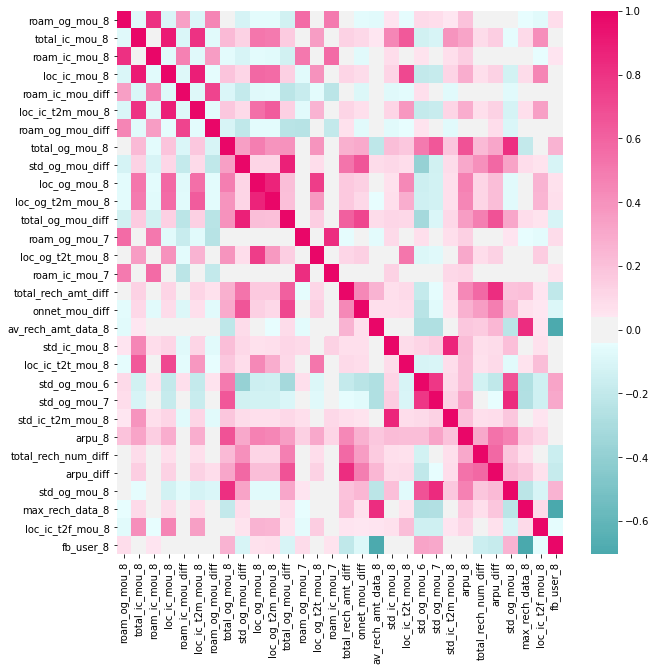

In [81]:
# plot feature correlation
import seaborn as sns
plt.rcParams["figure.figsize"] =(10,10)
mycmap = sns.diverging_palette(199, 359, s=99, center="light", as_cmap=True)
sns.heatmap(data=X_train[top_features].corr(), center=0.0, cmap=mycmap)

In [82]:
top_features = ['total_ic_mou_8', 'total_rech_amt_diff', 'total_og_mou_8', 'arpu_8', 'roam_ic_mou_8', 'roam_og_mou_8', 
                'std_ic_mou_8', 'av_rech_amt_data_8', 'std_og_mou_8']
X_train = X_train[top_features]
X_test = X_test[top_features]

In [83]:
# logistic regression
steps = [('scaler', StandardScaler()), 
         ("logistic", LogisticRegression(class_weight={0:0.1, 1:0.9}))
        ]

# compile pipeline
logistic = Pipeline(steps)

# hyperparameter space
params = {'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [84]:
# fit model
model.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logistic',
                                        LogisticRegression(class_weight={0: 0.1,
                                                                         1: 0.9}))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                         'logistic__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1)

In [85]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.9074881898301438
Best hyperparameters:  {'logistic__C': 10, 'logistic__penalty': 'l2'}


In [86]:
# predict churn on test data
y_pred = model.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("ROC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[6175  269]
 [  65  117]]
Sensitivity: 	0.64
Specificity: 	0.96
ROC:    	 0.93


### Extract the intercept and the coefficients from the logistic model 

In [87]:
logistic_model = model.best_estimator_.named_steps['logistic']

In [88]:
# intercept
intercept_df = pd.DataFrame(logistic_model.intercept_.reshape((1,1)), columns = ['intercept'])

In [89]:
# coefficients
coefficients = logistic_model.coef_.reshape((9, 1)).tolist()
coefficients = [val for sublist in coefficients for val in sublist]
coefficients = [round(coefficient, 3) for coefficient in coefficients]

logistic_features = list(X_train.columns)
coefficients_df = pd.DataFrame(logistic_model.coef_, columns=logistic_features)

In [90]:
# concatenate dataframes
coefficients = pd.concat([intercept_df, coefficients_df], axis=1)
coefficients

,intercept,total_ic_mou_8,total_rech_amt_diff,total_og_mou_8,arpu_8,roam_ic_mou_8,roam_og_mou_8,std_ic_mou_8,av_rech_amt_data_8,std_og_mou_8
0,-3.653918,-2.001799,-0.634517,-1.481348,0.000661,0.119015,0.419089,0.330727,-1.080881,1.411538


## Business Insights

* Telecom company needs to pay attention to the roaming rates. They need to provide good offers to the customers who are using services from a roaming zone.
* The company needs to focus on the STD and ISD rates. Perhaps, the rates are too high. Provide them with some kind of STD and ISD packages.
* To look into both of the issues stated above, it is desired that the telecom company collects customer query and complaint data and work on their services according to the needs of customers. 